# [LEGALST-190] Lab 4/12: Morality and Sentiment Analysis

This lab will cover morality and sentiment analysis using the *Moral Foundations Theory* with dictionary-based analysis, connecting to topic modeling and classifications ideas from previous labs.

### Table of Contents
[The Data](#section data)<br>
[Goal and Question](#section goal)<br>
1 - [Text Pre-processing](#section 1)<br>
2 - [General Sentiment Analysis](#section 2)<br>
3 - [Moral Foundations Theory](#section 3)<br>
4 - [Non-negative matrix factorization](#section 4)<br>

**Dependencies:**

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import json

from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

    100% |████████████████████████████████| 112kB 1.5MB/s ta 0:00:01


----
## The Data<a id='section data'></a>

For this lab, we'll use the Old Bailey dataset, something you all should be familiar with now. The size of the dataset is also rather large so we will compare two year-long periods, one from before 1827 and one after. Read the question to better understand why we look at 1827.

## Goal and Question<a id='section goal'></a>

The goal of today's lab is to explore sentiment analysis with three different approaches – [polarity scoring](#section 2), [topic-specific dictionary methods](#section 3), and [topic modeling](#section 4).

We'll look at sentiment in the context of the following question: 

**Did the way judges, prosecutors, and witnesses talk about moral culpability change after the Bloody Code was mostly repealed in 1827 (at the leading edge of a wave of legal reform in England)?**

*Note: this is a question that could encompass an entire research project. Today's lab uses a very small subset of data due to datahub memory limitations, and skips over many of the steps needed for truly robust conclusions. *

Something to think about: What are some things you would need to consider before answering this question?

----

## Section 1: Text Pre-processing<a id='section 1'></a>

### Before we start
This dataset we are about to look at is incredibly large, so for this lab, we only consider two years: 1822 and 1832.

**Question 1.1:** Why are we looking at these two years?

*Write your answer here.*

----

### Getting started

Let's get working with the data.

In [2]:
# contains Old Bailey trial data from 1822 and 1832
old_bailey = pd.read_csv('data/obc_1822_1832.csv', index_col='trial_id')


Awesome! We now have data we can work with. Before we start anything, we must clean the text!

Just to review, we want to process our text by:<br>
1) Lowercasing the words<br>
2) Cleaning up punctuation<br>
3) Creating a list of tokens<br>

<a id='gensim'></a>**Question 1.5:** Clean up the data based on these steps. 

*Note: as a general practice, it's a good idea not to modify the data in-place, in case you need it later. Instead, put your cleaned data in a new column where each value is a list of the tokens.*

In [ ]:
# clean the transcripts

In [9]:
#SOLUTION
lower_cased = old_bailey['transcript'].str.lower()
punct_re = r'[^\w\s]'
lower_no_punc = lower_cased.str.replace(punct_re, ' ')
tokens = lower_no_punc.str.split()
old_bailey['tokens'] = tokens
old_bailey.head()

,offense,offense_subcategory,punishment,punishment_subcategory,session,transcript,verdict,verdict_subcategory,year,tokens
trial_id,,,,,,,,,,
t18170115-1,miscellaneous,returnFromTransportation,death,none,18170115,"PETER JOHNSON was indicted for being at large,...",guilty,pleadedGuilty,1822,"[peter, johnson, was, indicted, for, being, at..."
t18170115-2,theft,burglary,transport,none,18170115,BENJAMIN HEARNE was indicted for burglariously...,guilty,lesserOffence,1822,"[benjamin, hearne, was, indicted, for, burglar..."
t18170115-3,theft,housebreaking,uncategorized,none,18170115,"JOHN DAVIS and JAMES LEMON , were indicted for...",specialVerdict,none,1822,"[john, davis, and, james, lemon, were, indicte..."
t18170115-4,theft,pocketpicking,uncategorized,none,18170115,"RICHARD WILTSHIRE and SUSAN PAR-SONS , were in...",notGuilty,none,1822,"[richard, wiltshire, and, susan, par, sons, we..."
t18170115-5,theft,burglary,death,none,18170115,MARY JOHNSTON was indicted for burglariously b...,guilty,withRecommendation,1822,"[mary, johnston, was, indicted, for, burglario..."


----

## Section 2: General Sentiment Analysis<a id='section 2'></a>

One way to measure the tone of a text is to look at the text **polarity**: a measure of how positive or negative it is perceived to be. For example, a sentence like "I love Berkeley!" would be considered positive, while a sentence like "Stanfurd is terrible!" would be negative. And, because polarity is represented as a scale, some words have stronger positive or negative sentiment than others- "I like data science" is positive, but not as positive as "I love data science."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of Old Bailey. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which may or may not be great for our usage.

The VADER lexicon gives the sentiment of individual words. Run the following cell to show the first few rows of the lexicon. 

In [33]:
print(''.join(open("data/vader_lexicon.txt").readlines()[:10]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



As you can see, the lexicon contains emojis too (probably not common in early-19th century court transcripts)! The first column of the lexicon is the *token*, or the word itself. The second column is the *polarity* of the word, or how positive / negative it is.

Before we get started, it's important to consider how the lexicon was created. From the documentation:

>Sentiment ratings [were] from 10 independent human raters (all pre-screened, trained, and quality checked for optimal inter-rater reliability). Over 9,000 token features were rated on a scale from "[–4] Extremely Negative" to "[4] Extremely Positive", with allowance for "[0] Neutral (or Neither, N/A)".

To analyze sentiment, create an analyzer using `SentimentIntensityAnalyzer()`

In [30]:
# creates a sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

{'compound': 0.9195, 'neg': 0.0, 'neu': 0.235, 'pos': 0.765}

The analyzer's method `.polarity_scores` returns polarity for a given sentence.

In [37]:
# get the polarity
example_scores = analyzer.polarity_scores("This is a super exciting, totally awesome test sentence.")
example_scores

{'compound': 0.9195, 'neg': 0.0, 'neu': 0.235, 'pos': 0.765}

The VADER docs explain the scoring best:
   >*The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive)...It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:*

        positive sentiment: compound score >= 0.05
        neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
        negative sentiment: compound score <= -0.05

>    *The pos, neu, and neg scores are ratios for proportions of text that fall in each category (so these should all add up to be 1... or close to it with float operation). These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.*

We're most interested in the compound score. Since `polarity_scores` returns a dictionary, we can get the compound score like so:

In [38]:
# extract the compound score
example_scores['compound']

0.9195

Back to our transcripts. First, since the analyzer operates on sentences we'll need to tokenize our texts into sentences.

**Question:** Create a column in `old_bailey` called `sent_tokens` that contains a list of the sentences in each transcript. 

Hint: `.apply` can be used on a column to apply a function to every value in the column, and `sent_tokenize` splits a string into a list of individual sentences.

In [35]:
from nltk.tokenize import sent_tokenize
old_bailey['sent_tokens'] = old_bailey['transcript'].apply(sent_tokenize)

Next, we want to get the average polarity for each transcript. This takes 

1. 

In [39]:
# empty list where we'll collect the average polarity of each transcript
avg_transcript_polarity = []

# iterate through the transcripts
for transcript in old_bailey['sent_tokens']:
    # a list of the compound polarity scores of this transcript's sentences
    compound_scores = []
    # the number of sentences in this transcript
    num_sentences = len(sent_list)
    #iterate through the sentences in this transcript
    for sentence in transcript:
        # get the polarity scores of the sentence
        scores = analyzer.polarity_scores(sentence)
        # get the compound score of the sentence
        compound = scores['compound']
        # add the compound score to the list of scores
        compound_scores.append(compound)
    # get the average of the compound scores
    avg_compound = compound_sum / num_sentences
    # add the average to the list of averages
    avg_transcript_polarity.append(avg_compound)

In [41]:
old_bailey['avg_compound_polarity'] = avg_transcript_polarity
old_bailey.head()

,offense,offense_subcategory,punishment,punishment_subcategory,session,transcript,verdict,verdict_subcategory,year,tokens,authority/subversion,care/harm,fairness/cheating,loyalty/betrayal,sanctity/degradation,total_words,sent_tokens,avg_polarity,avg_compound_polarity
trial_id,,,,,,,,,,,,,,,,,,,
t18170115-1,miscellaneous,returnFromTransportation,death,none,18170115,"PETER JOHNSON was indicted for being at large,...",guilty,pleadedGuilty,1822,"[peter, johnson, was, indicted, for, being, at...",2.222222,0.000000,0.000000,0.0,0.0,45,[PETER JOHNSON was indicted for being at large...,-0.304333,-0.304333
t18170115-2,theft,burglary,transport,none,18170115,BENJAMIN HEARNE was indicted for burglariously...,guilty,lesserOffence,1822,"[benjamin, hearne, was, indicted, for, burglar...",0.000000,0.523560,0.261780,0.0,0.0,382,[BENJAMIN HEARNE was indicted for burglariousl...,0.017689,0.017689
t18170115-3,theft,housebreaking,uncategorized,none,18170115,"JOHN DAVIS and JAMES LEMON , were indicted for...",specialVerdict,none,1822,"[john, davis, and, james, lemon, were, indicte...",0.101937,0.203874,0.101937,0.0,0.0,981,"[JOHN DAVIS and JAMES LEMON , were indicted fo...",-0.162076,-0.162076
t18170115-4,theft,pocketpicking,uncategorized,none,18170115,"RICHARD WILTSHIRE and SUSAN PAR-SONS , were in...",notGuilty,none,1822,"[richard, wiltshire, and, susan, par, sons, we...",0.000000,0.537634,0.268817,0.0,0.0,372,"[RICHARD WILTSHIRE and SUSAN PAR-SONS , were i...",-0.068257,-0.068257
t18170115-5,theft,burglary,death,none,18170115,MARY JOHNSTON was indicted for burglariously b...,guilty,withRecommendation,1822,"[mary, johnston, was, indicted, for, burglario...",0.103842,0.000000,0.103842,0.0,0.0,963,[MARY JOHNSTON was indicted for burglariously ...,-0.167620,-0.167620


**QUESTION:** 
- What was the most negative transcript?
- What was the most positive transcript?


In [52]:
# find the transcript with the highest average compound polarity
most_pos = old_bailey[old_bailey['avg_compound_polarity'] == old_bailey['avg_compound_polarity'].max()]

for t in most_pos['transcript']:
    print(t)
    print('\n')

GEORGE ROWE was indicted for burglariously breaking and entering the dwelling-house of William James Paul , and burglariously stealing therein six fowls, value 12s., his property .The prosecutor not appearing, the prisoner was ACQUITTED .Second Middlesex Jury, before Mr. Baron Graham .


MONTAGUE LEWIS was indicted for stealing, on the 19th of November, ten pair of stockings, value 15s., the goods of Samuel Everington , privately in his shop .The witnesses not appearing, the prisoner was ACQUITTED .Second Middlesex Jury, before Mr. Barron Garrow.


JOHN JETTER was indicted for stealing, on the 6th of November, one handkerchief, value 5s., the goods of James Wait , from his person .The prosecutor not appearing, the prisoner was ACQUITTED .Second Middlesex Jury, before Mr. Baron Garrow.




In [ ]:
print('Most negative statement 1840:')
for t in after_1827.sort_values('polarity').head()['transcript']:
    print('\n  ', t)

**Question 2.4:** Let's take a look at violin plots of these two datasets to better compare how the sentiment is between the two dates, before and after 1827.

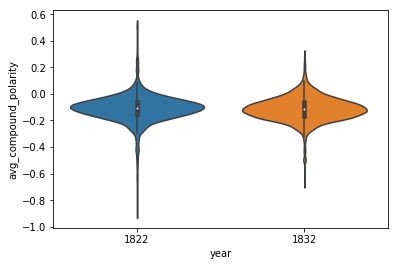

In [56]:
#SOLUTION
old_bailey_violin = sns.violinplot(x="year", y="avg_compound_polarity", data=old_bailey)

What does this plot show us?

What are some pros and cons to this approach?

*Write your answer here.*

----
## Section 3: Moral Foundations Theory<a id='section 3'></a>

Something to consider when looking at sentiment, outside of just general polarity like we did in the last section, people can create specialized dictionaries containing specific words of interest to try to analyze sentiment from a particular angle. One organization, the [Moral Foundations Theory](http://moralfoundations.org/), took this approach and we will now use it to see if we can understand Old Bailey's sentiment better. You should be doing something like this for your homework. We will be using a provided moral foundations dictionary.

In [6]:
with open('data/haidt_dict.json') as json_data:
    haidt_dict = json.load(json_data)

In [ ]:
#look at the keys of the dictionary provided
keys = haidt_dict.keys()
list(keys)

In [ ]:
haidt_dict[list(keys)[0]] #one example of the values provided for the first key

**Question 3.1**: Read through the document and write what you think.

*Write your answer here.*

Now that we have our `old_bailey` data and a dictionary, we can start our exploratory analysis.

To get a sense of how Moral Foundations words were used in statements, we'll do three things:

1) Count the occurances of words from our dictionary in each statement<br>
2) Calculate how often words from each category are used by in each year<br>
3) Plot the percents on a bar graph<br>

Think about what you know about Moral Foundations Theory.

### Calculating Percentages 

We're interesting in knowing the percent of words that correspond to a Moral Foundation in speeches- in other words, how often statements contained words related to a specific foundation.

(Bonus question: why don't we just use the number of Moral Foundation words instead of the percent as our test statistic?)

**Question 3.2:** To calculate the percent, we'll first need the total number of words in each statement.

In [7]:
stemmer = SnowballStemmer('english')
stem_lists = []

for token_list in old_bailey['tokens']:
    stem_lists.append([stemmer.stem(wd) for wd in token_list])
    


In [ ]:
old_bailey['stemmed_tokens'] = stem_lists
old_bailey.head()

In [ ]:
# create a new column called 'total_words'
old_bailey['total_words'] = ...
old_bailey.head()

In [11]:
# SOLUTION
old_bailey['total_words'] = [len(statement) for statement in old_bailey['tokens']]
old_bailey.head()

,offense,offense_subcategory,punishment,punishment_subcategory,session,transcript,verdict,verdict_subcategory,year,tokens,authority/subversion,care/harm,fairness/cheating,loyalty/betrayal,sanctity/degradation,total_words
trial_id,,,,,,,,,,,,,,,,
t18170115-1,miscellaneous,returnFromTransportation,death,none,18170115,"PETER JOHNSON was indicted for being at large,...",guilty,pleadedGuilty,1822,"[peter, johnson, was, indicted, for, being, at...",1.0,0.0,0.0,0.0,0.0,45
t18170115-2,theft,burglary,transport,none,18170115,BENJAMIN HEARNE was indicted for burglariously...,guilty,lesserOffence,1822,"[benjamin, hearne, was, indicted, for, burglar...",0.0,2.0,1.0,0.0,0.0,382
t18170115-3,theft,housebreaking,uncategorized,none,18170115,"JOHN DAVIS and JAMES LEMON , were indicted for...",specialVerdict,none,1822,"[john, davis, and, james, lemon, were, indicte...",1.0,2.0,1.0,0.0,0.0,981
t18170115-4,theft,pocketpicking,uncategorized,none,18170115,"RICHARD WILTSHIRE and SUSAN PAR-SONS , were in...",notGuilty,none,1822,"[richard, wiltshire, and, susan, par, sons, we...",0.0,2.0,1.0,0.0,0.0,372
t18170115-5,theft,burglary,death,none,18170115,MARY JOHNSTON was indicted for burglariously b...,guilty,withRecommendation,1822,"[mary, johnston, was, indicted, for, burglario...",1.0,0.0,1.0,0.0,0.0,963


Next, we need to calculate the number of matches to entries in our dictionary for each foundation for each speech.

Run the next cell to add six new columns to `old_bailey`, one per foundation, that show the number of word matches.

In [10]:
#Note: much of the following code is not covered in these modules. Read the comments to get a sense of what it does.
#Will take a bit of time to run due to the large size.

# do the following code for each foundation
for foundation in haidt_dict.keys():
    # create a new, empty column
    num_match_words = np.zeros(len(old_bailey))
    stems = haidt_dict[foundation]
    
    # do the following code for each foundation word
    for stem in stems:
        # find synonym matches
        wd_count = np.array([sum([wd.startswith(stem) for wd in statement]) for statement in old_bailey['tokens']])
        # add the number of matches to the total
        num_match_words += wd_count
        
    # create a new column for each foundation with the number of foundation words per speech
    old_bailey[foundation] = num_match_words

old_bailey.head()

,offense,offense_subcategory,punishment,punishment_subcategory,session,transcript,verdict,verdict_subcategory,year,tokens,authority/subversion,care/harm,fairness/cheating,loyalty/betrayal,sanctity/degradation
trial_id,,,,,,,,,,,,,,,
t18170115-1,miscellaneous,returnFromTransportation,death,none,18170115,"PETER JOHNSON was indicted for being at large,...",guilty,pleadedGuilty,1822,"[peter, johnson, was, indicted, for, being, at...",1.0,0.0,0.0,0.0,0.0
t18170115-2,theft,burglary,transport,none,18170115,BENJAMIN HEARNE was indicted for burglariously...,guilty,lesserOffence,1822,"[benjamin, hearne, was, indicted, for, burglar...",0.0,2.0,1.0,0.0,0.0
t18170115-3,theft,housebreaking,uncategorized,none,18170115,"JOHN DAVIS and JAMES LEMON , were indicted for...",specialVerdict,none,1822,"[john, davis, and, james, lemon, were, indicte...",1.0,2.0,1.0,0.0,0.0
t18170115-4,theft,pocketpicking,uncategorized,none,18170115,"RICHARD WILTSHIRE and SUSAN PAR-SONS , were in...",notGuilty,none,1822,"[richard, wiltshire, and, susan, par, sons, we...",0.0,2.0,1.0,0.0,0.0
t18170115-5,theft,burglary,death,none,18170115,MARY JOHNSTON was indicted for burglariously b...,guilty,withRecommendation,1822,"[mary, johnston, was, indicted, for, burglario...",1.0,0.0,1.0,0.0,0.0


**Question 3.3:** To calculate the percentage of foundation words per speech, divide the number of matched words by the number of total words and multiply by 100.

In [ ]:
for foundation in haidt_dict.keys():
    old_bailey[foundation] = ...

old_bailey.head()

In [12]:
#SOLUTION
for foundation in haidt_dict.keys():
    old_bailey[foundation] = (old_bailey[foundation] / old_bailey['total_words']) * 100

old_bailey.head()

,offense,offense_subcategory,punishment,punishment_subcategory,session,transcript,verdict,verdict_subcategory,year,tokens,authority/subversion,care/harm,fairness/cheating,loyalty/betrayal,sanctity/degradation,total_words
trial_id,,,,,,,,,,,,,,,,
t18170115-1,miscellaneous,returnFromTransportation,death,none,18170115,"PETER JOHNSON was indicted for being at large,...",guilty,pleadedGuilty,1822,"[peter, johnson, was, indicted, for, being, at...",2.222222,0.000000,0.000000,0.0,0.0,45
t18170115-2,theft,burglary,transport,none,18170115,BENJAMIN HEARNE was indicted for burglariously...,guilty,lesserOffence,1822,"[benjamin, hearne, was, indicted, for, burglar...",0.000000,0.523560,0.261780,0.0,0.0,382
t18170115-3,theft,housebreaking,uncategorized,none,18170115,"JOHN DAVIS and JAMES LEMON , were indicted for...",specialVerdict,none,1822,"[john, davis, and, james, lemon, were, indicte...",0.101937,0.203874,0.101937,0.0,0.0,981
t18170115-4,theft,pocketpicking,uncategorized,none,18170115,"RICHARD WILTSHIRE and SUSAN PAR-SONS , were in...",notGuilty,none,1822,"[richard, wiltshire, and, susan, par, sons, we...",0.000000,0.537634,0.268817,0.0,0.0,372
t18170115-5,theft,burglary,death,none,18170115,MARY JOHNSTON was indicted for burglariously b...,guilty,withRecommendation,1822,"[mary, johnston, was, indicted, for, burglario...",0.103842,0.000000,0.103842,0.0,0.0,963


**Question 3.4:** Is there anything strange you notice?

*Write your answer here.*

Let's separate the two dates, 1810 and 1840, again like we did earlier in the lab. Then we will create two bar graphs.

**Question 3.5:** Make a table `transcript_1810` and a table `transcript_1840` so we can compare the two datasets separately. Then create two separate bar graphs for the two datasets.

In [ ]:
transcript_1810 = ...

# select the foundations columns and calculate the mean percent for each
avg_1810_stats = (transcript_1810.loc[:, ...]
                 .apply(np.mean)
                 .to_frame('1810_percent'))

avg_1810_stats

In [13]:
#SOLUTION
transcript_1822 = old_bailey[old_bailey['year'] == 1822]

# select the foundations columns and calculate the mean percent for each
avg_1822_stats = (transcript_1822.loc[:, list(haidt_dict.keys())]
                 .apply(np.mean)
                 .to_frame('1822_percent'))

avg_1822_stats

,1822_percent
authority/subversion,0.108437
care/harm,0.427047
fairness/cheating,0.102971
loyalty/betrayal,0.049865
sanctity/degradation,0.057021


In [ ]:
avg_1810_stats.plot.barh();

In [ ]:
transcript_1840 = ...

# select the foundations columns and calculate the mean percent for each
avg_1840_stats = (transcript_1840.loc[:, ...]
                 .apply(np.mean)
                 .to_frame('1840_percent'))

avg_1840_stats

In [15]:
#SOLUTION
transcript_1832 = old_bailey[old_bailey['year'] == 1832]

# select the foundations columns and calculate the mean percent for each
avg_1832_stats = (transcript_1832.loc[:, list(haidt_dict.keys())]
                 .apply(np.mean)
                 .to_frame('1832_percent'))

avg_1832_stats

,1832_percent
authority/subversion,0.183081
care/harm,0.326695
fairness/cheating,0.031621
loyalty/betrayal,0.050915
sanctity/degradation,0.088442


In [ ]:
avg_1832_stats.plot.barh();

In [ ]:
all_avg_stats = ...
all_avg_stats

In [17]:
#SOLUTION
all_avg_stats = avg_1832_stats.join(avg_1822_stats)
all_avg_stats

,1832_percent,1822_percent
authority/subversion,0.183081,0.108437
care/harm,0.326695,0.427047
fairness/cheating,0.031621,0.102971
loyalty/betrayal,0.050915,0.049865
sanctity/degradation,0.088442,0.057021


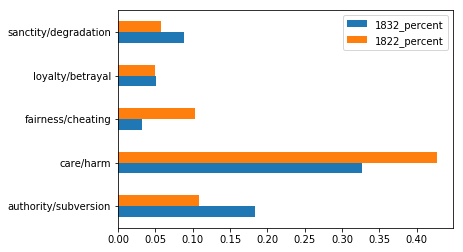

In [18]:
all_avg_stats.plot.barh();

**Question 3.6:** What are some pros of this method? Cons?

*Write your answer here.*

*Potential answer: Rarity of words means results may not be significant.*

----
## Section 4: Non-negative matrix factorization<a id='section 4'></a>

In this section, you can get an idea of sentiment using topic modeling algorithsm, something you touched on in the 4/10 lab earlier this week, to help look for patterns.

The creation of the bag of words matrix is very easy in Scikit Learn with all of the heavy lifting done by the feature extraction functionality provided for text datasets. A tf-idf transformer is applied to the bag of words matrix that NMF must process with the TfidfVectorizer. Stop words are removed and the number of terms included in the bag of words matrix is restricted to the top 1000.

**Question 4.1:** Fill in the elipses so we can create a tfidf for our NMF.

**Hint:** Look up the code for TfidfVEctorizer to better understand what this code is doing. 

In [ ]:
no_features = ...

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=..., stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(...) #add the column with the statements
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [ ]:
#SOLUTION
no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(old_bailey['transcript'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

As mentioned previously the algorithms are not able to automatically determine the number of topics and this value must be set when running the algorithm. Initialising the W and H matrices in NMF with ‘nndsvd’ rather than random initialisation improves the time it takes for NMF to converge.

**Question 4.2:** Fill in the number of components we use and what we are fitting our NMF on.

In [ ]:
no_topics = 20
# Run NMF
nmf = NMF(n_components=..., random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(...)

In [ ]:
#SOLUTION
no_topics = 20
# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

We've provided you the function to display the topics shown by the NMF.

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)

**Question 4.3:** Now what did you think of this approach? It should be similar to what you learned before so we don't go into too much depth with it. Are there any pros and cons you might consider?

*Write your answer here.*

*Potential answer: Unstructured data means you might have to dig a lot to find relevant topics.*

----
Fantastic! Now you know how to cover morality and sentiment analysis two ways using general sentiment analysis with `VADER`, Moral Foundations Theory, and Non-negative matrix factorization.

Now see if you can answer our main question of today: 

**Question:** Did the way judges, prosecutors, and witnesses talk about moral culpability change after the Bloody Code was mostly repealed in 1827 (at the leading edge of a wave of legal reform in England)?

----

## Bibliography

 - Work done with text analysis. https://github.com/DS-100/sp18/blob/master/proj/proj1/solution/proj1_solution.ipynb
 - *Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.*
 - Moral Foundations Theory background: http://moralfoundations.org/
 - Moral Foundations analysis https://github.com/ds-modules/XRHETOR-R1A/blob/master/02-Moral-Foundations-Analysis/02-Moral-Foundations-Analysis.ipynb
- VADER sentiment tools: Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

----
Notebook developed by: Gibson Chu

Data Science Modules: http://data.berkeley.edu/education/modules